In [5]:
# Imports
# if any package errors out, install it using pip install <package name>
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sdeint
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

from src import ParameterSet
from src import ModelBase as Model


In [8]:


def solve(f, g, y0: np.array, t: np.array):
    y = sdeint.itoint(f, g, y0, t)
    # return y
    def toState(y): return Model().deserialize(y)
    return list(map(toState, y))


def run(t_end, dt=0.0001):
    print(f'estimated time: {1.1 * t_end/dt / 1000} seconds')
    t = np.linspace(0, t_end, int(t_end / dt) + 1)
    y0 = Model()
    y0.initialize()
    params = ParameterSet("structure.json")
    sigma = y0.serialize_g(params)
    g_vector = sigma * params.constants.tau_y

    def model_f(y, t):
        Y = Model().deserialize(y)
        delta = Y.calcDelta(t, params)
        return delta.serialize()

    def model_g(y, t):
        # Y = MyState().deserialize(y)
        # sigma = Y.serialize_g(params)
        # tau_y = params.constants.tau_y
        # g = sigma * tau_y
        return np.diag(g_vector)

    res = sdeint.itoint(model_f, model_g, y0.serialize(), t)
    def toState(y): return Model().deserialize(y)
    return t, list(map(toState, res))


In [10]:
t, res = run(10)

estimated time: 100.0 seconds


/Users/pooya/Documents/neural-simulation/src/model_base.py:68: RuntimeWarning: overflow encountered in scalar multiply
  gamma_r *= (1-n.s)
/Users/pooya/Documents/neural-simulation/src/model_base.py:38: RuntimeWarning: invalid value encountered in scalar multiply
  n_dest._input += n_src.s * \
/Users/pooya/Documents/neural-simulation/venv/lib/python3.9/site-packages/sdeint/integrate.py:509: RuntimeWarning: invalid value encountered in add
  H20 = Yn + fnh # shape (d,)


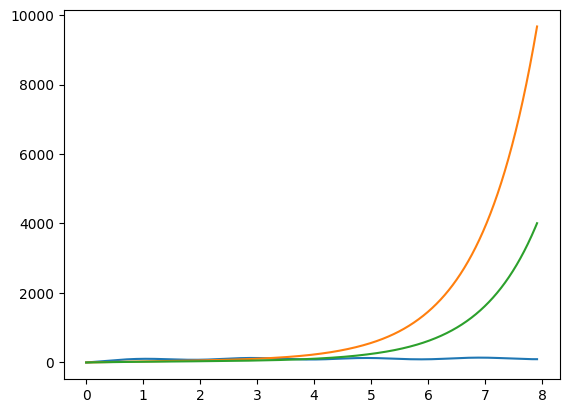

In [11]:
exc1_r = np.array([x.exc1.r for x in res])
exc2_r = np.array([x.exc2.r for x in res])
pv_r = np.array([x.pv.r for x in res])
plt.plot(t, exc1_r)
plt.plot(t, exc2_r)
plt.plot(t, pv_r)